Pull data from snotel data base and analyze time series to see if there are any discernable trends. Output results to HTML so that it could be easily loaded in a website.

In [1]:
import pandas as pd
import csv
import requests
import os

In [5]:
# change to the path with the raw csv file
path=r'C:\Springboard\Github\snotel\analysis'
os.chdir(path)

In [6]:
# function to clean the inputs for the database
def clean_up(num):
    try:
        return float(num)
    except:
        return 0

In [9]:
# Pull the data just for the first snotel site on the list
url='https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/301:CA:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/SNWD::value,WTEQ::value,SNWD::delta?fitToScreen=false'
response = requests.get(url)

# read raw CSV to clean CSV - eliminate comment rows with "#"
clean_file = 'clean.csv'
with open(clean_file, 'w') as fo:
    for line in response.text.splitlines():
        if "#" not in line:
            fo.write(line + '\n')

In [22]:
# read result back in as PD
snow = pd.read_csv(clean_file, error_bad_lines=False)
snow

,Date,Adin Mtn (301) Snow Depth (in) Start of Day Values,Adin Mtn (301) Snow Water Equivalent (in) Start of Day Values,Adin Mtn (301) Change In Snow Depth (in) Start of Day Values
0,1984-10-01,NaN,0.0,NaN
1,1984-10-02,NaN,0.0,NaN
2,1984-10-03,NaN,0.0,NaN
3,1984-10-04,NaN,0.0,NaN
4,1984-10-05,NaN,0.0,NaN
...,...,...,...,...
13530,2021-10-17,0.0,0.1,0.0
13531,2021-10-18,0.0,0.2,0.0
13532,2021-10-19,0.0,0.2,0.0
13533,2021-10-20,0.0,0.1,0.0


That's what we want. Now we just need to eliminate the NaN values: fill the first row with 0 and then use the previous value to fill all the other Nan.

In [23]:
snow.loc[0]

Date                                                             1984-10-01
Adin Mtn (301) Snow Depth (in) Start of Day Values                      NaN
Adin Mtn (301) Snow Water Equivalent (in) Start of Day Values             0
Adin Mtn (301) Change In Snow Depth (in) Start of Day Values            NaN
Name: 0, dtype: object

In [34]:
# rename columns
snow.columns = ['ds', 'Depth', 'Water', 'y']

In [35]:
snow.fillna(value=0, inplace=True)

In [36]:
snow

,ds,Depth,Water,y
0,1984-10-01,0.0,0.0,0.0
1,1984-10-02,0.0,0.0,0.0
2,1984-10-03,0.0,0.0,0.0
3,1984-10-04,0.0,0.0,0.0
4,1984-10-05,0.0,0.0,0.0
...,...,...,...,...
13530,2021-10-17,0.0,0.1,0.0
13531,2021-10-18,0.0,0.2,0.0
13532,2021-10-19,0.0,0.2,0.0
13533,2021-10-20,0.0,0.1,0.0


INFO:numexpr.utils:NumExpr defaulting to 4 threads.


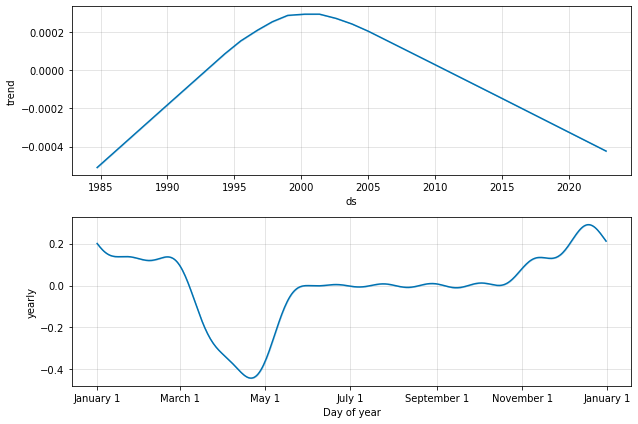

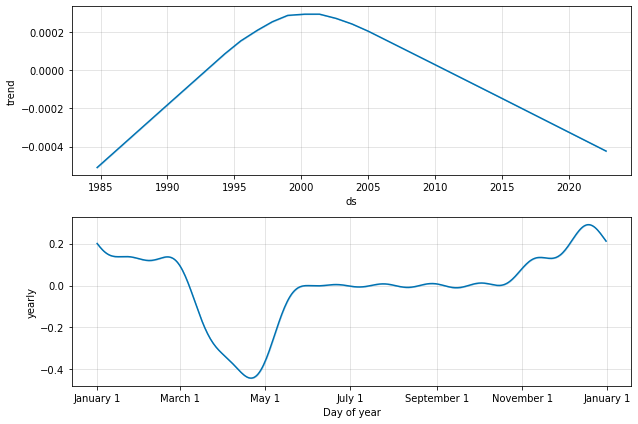

In [37]:
# let's take a better look at this with FB's Prophet - not considering any other regressors yet
from fbprophet import Prophet
m_fb = Prophet(yearly_seasonality = True, daily_seasonality=False, weekly_seasonality=False)
m_fb.fit(snow)
future = m_fb.make_future_dataframe(periods=365)
forecast = m_fb.predict(future)
m_fb.plot_components(forecast)

That looks OK, but I want more consistent values. I think the loss of snow may also be hurting the values. I will remove the negative values and do a 7-day sum.

In [45]:
# let's set the new "y" column to not have snowfall that is less than 0 and see how that effects the analysis
snow.rename(columns={'y':'new'}, inplace=True)

In [47]:
snow['new']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
13530    0.0
13531    0.0
13532    0.0
13533    0.0
13534    0.0
Name: new, Length: 13535, dtype: float64

In [52]:
snow['acc'] = [v if v >= 0 else 0 for v in snow['new']]
# [snow['new'] if snow['new'] >= 0 else 0]

In [53]:
snow

,ds,Depth,Water,new,acc
0,1984-10-01,0.0,0.0,0.0,0.0
1,1984-10-02,0.0,0.0,0.0,0.0
2,1984-10-03,0.0,0.0,0.0,0.0
3,1984-10-04,0.0,0.0,0.0,0.0
4,1984-10-05,0.0,0.0,0.0,0.0
...,...,...,...,...,...
13530,2021-10-17,0.0,0.1,0.0,0.0
13531,2021-10-18,0.0,0.2,0.0,0.0
13532,2021-10-19,0.0,0.2,0.0,0.0
13533,2021-10-20,0.0,0.1,0.0,0.0


In [58]:
# checking myself to make sure they are all positive
snow['acc'].value_counts()

0.0     12611
1.0       397
2.0       174
3.0       129
4.0        72
5.0        60
6.0        29
7.0        27
9.0        11
8.0        10
10.0        5
12.0        4
13.0        3
11.0        3
Name: acc, dtype: int64

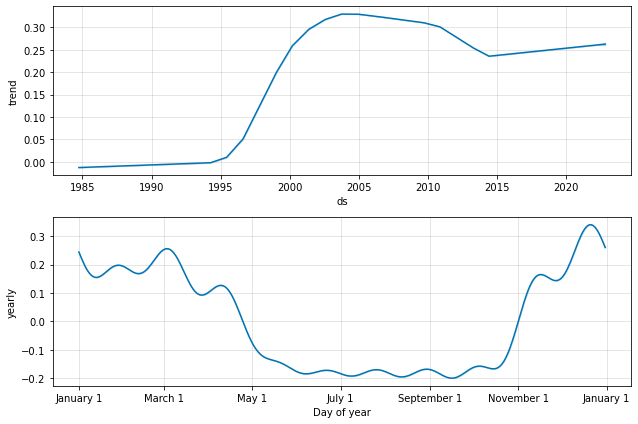

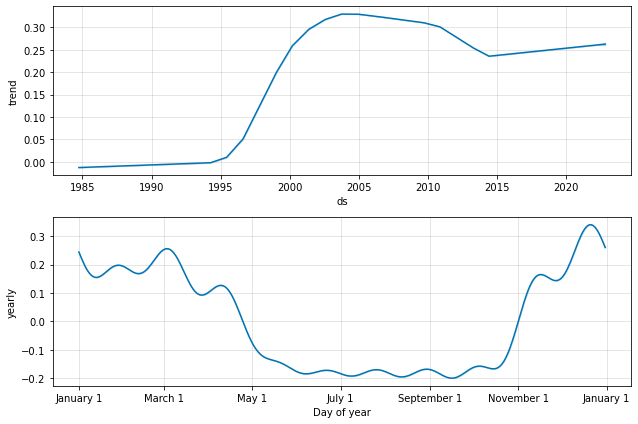

In [59]:
# let's rename and run the analysis again
snow.rename(columns={'acc':'y'}, inplace=True)
m_fb = Prophet(yearly_seasonality = True, daily_seasonality=False, weekly_seasonality=False)
m_fb.fit(snow)
future = m_fb.make_future_dataframe(periods=365)
forecast = m_fb.predict(future)
m_fb.plot_components(forecast)

Those look so much better! Let's try it with a 7-day accumulation.

In [60]:
snow["acc7"] = snow.rolling(window=7)['y'].sum()

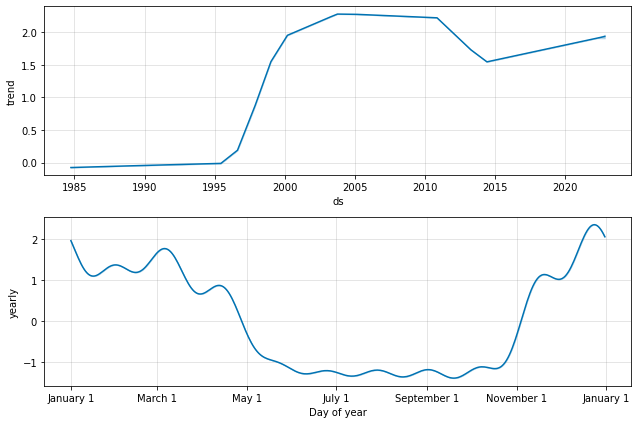

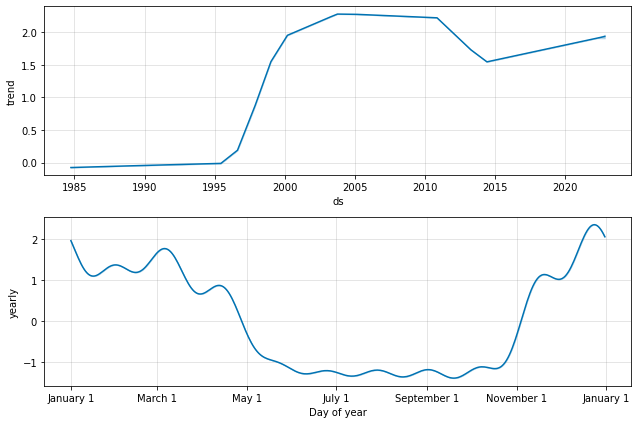

In [61]:
snow.rename(columns={'y':'acc', 'acc7':'y'}, inplace=True)
m_fb = Prophet(yearly_seasonality = True, daily_seasonality=False, weekly_seasonality=False)
m_fb.fit(snow)
future = m_fb.make_future_dataframe(periods=365)
forecast = m_fb.predict(future)
m_fb.plot_components(forecast)